In [6]:
from functools import partial
from pathlib import Path
from typing import Optional, Tuple

import cv2
import fire
import numpy as np
import torch
import torch.nn.functional as F
#from accelerate import Accelerator
from PIL import Image
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm

torch.multiprocessing.set_sharing_strategy('file_system')

import extract_utils

import gc

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

def clear_gpu():
    torch.cuda.empty_cache()
    print(gc.collect())

cuda


In [2]:
clear_gpu()

0


In [3]:
RESIZE = 256
PATHSIZE = 16
NUM_PATCHES = RESIZE // PATHSIZE

In [4]:
def extract_features(
    images_list: str,
    images_root: Optional[str],
    model_name: str,
    batch_size: int,
    output_dir: str,
    which_block: int = -1,
    common_size=RESIZE,
):
    """
    Extract features from a list of images.

    Example:
        python extract.py extract_features \
            --images_list "./data/VOC2012/lists/images.txt" \
            --images_root "./data/VOC2012/images" \
            --output_dir "./data/VOC2012/features/dino_vits16" \
            --model_name dino_vits16 \
            --batch_size 1
    """

    # Output
    extract_utils.make_output_dir(output_dir)

    # Models
    model_name = model_name.lower()
    model, val_transform, patch_size, num_heads = extract_utils.get_model(model_name)

    # Add hook
    if 'dino' in model_name or 'mocov3' in model_name:
        feat_out = {}
        def hook_fn_forward_qkv(module, input, output):
            feat_out["qkv"] = output
        model._modules["blocks"][which_block]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)
    else:
        raise ValueError(model_name)

    # Dataset
    filenames = Path(images_list).read_text().splitlines()
    dataset = extract_utils.ImagesDataset(filenames=filenames, images_root=images_root, transform=val_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=8)
    print(f'Dataset size: {len(dataset)=}')
    print(f'Dataloader size: {len(dataloader)=}')

    # Prepare
    # accelerator = Accelerator(fp16=True, cpu=False) ORIGINAL VERSION
    accelerator = Accelerator(cpu=False, mixed_precision='fp16') # ADDED BY MEKHRON
    # model, dataloader = accelerator.prepare(model, dataloader)
    model = model.to(accelerator.device)
    
    all_outputs = {'indices':[], 'file':[], 'id': [], 'q': [], 'k': [], 'v': [], 'old_shape': [], 'new_shape_and_path_size': []}
    
    # Process
    pbar = tqdm(dataloader, desc='Processing')
    for i, (images, files, indices) in enumerate(pbar):
        output_dict = {}

        # Check if file already exists
        id = Path(files[0]).stem
        # output_file = Path(output_dir) / f'{id}.pth'
        # if output_file.is_file():
        #     pbar.write(f'Skipping existing file {str(output_file)}')
        #     continue

        # Reshape image
        # # images = F.interpolate(images, size=(H_pad, W_pad), mode='bilinear')  # resize image
        # images = images[:, :, :H_pad, :W_pad]
        all_outputs['old_shape'].append(images.shape[2:])
        
        images = cv2.resize(np.array(images.squeeze().permute(1, 2, 0)), dsize=(common_size, common_size), interpolation=cv2.INTER_NEAREST)
        images = torch.from_numpy(images).permute(2, 0, 1).unsqueeze(0).to(accelerator.device)
        
        P = patch_size
        B, C, H, W = images.shape
        H_patch, W_patch = H // P, W // P
        H_pad, W_pad = H_patch * P, W_patch * P
        T = H_patch * W_patch + 1  # number of tokens, add 1 for [CLS]
        
        all_outputs['new_shape_and_path_size'].append((H, W, P))

        # Forward and collect features into output dict
        if 'dino' in model_name or 'mocov3' in model_name:
            # accelerator.unwrap_model(model).get_intermediate_layers(images)[0].squeeze(0)
            model.get_intermediate_layers(images)[0].squeeze(0)
            # output_dict['out'] = out
            output_qkv = feat_out["qkv"].reshape(B, T, 3, num_heads, -1 // num_heads).permute(2, 0, 3, 1, 4)
            # output_dict['q'] = output_qkv[0].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
            #all_outputs['k'].append(output_qkv[1].transpose(1, 2).reshape(B, T, -1)[:, 1:, :].detach().cpu()) # ACSeg
            all_outputs['q'].append(output_qkv[0].transpose(1, 2).reshape(B, T, -1).detach().cpu())
            all_outputs['k'].append(output_qkv[1].transpose(1, 2).reshape(B, T, -1).detach().cpu())
            all_outputs['v'].append(output_qkv[2].transpose(1, 2).reshape(B, T, -1).detach().cpu())
            #output_dict['k'] = output_qkv[1].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
            # output_dict['pixel_representation'] = F.interpolate(
            #     output_dict['k'].squeeze().T.reshape(1, -1, H_patch, W_patch), 
            #     size=(H, W), mode='bilinear', align_corners=False)
            
            # output_dict['v'] = output_qkv[2].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
        else:
            raise ValueError(model_name)

        # Metadata
        # output_dict['indices'] = indices[0]
        # output_dict['file'] = files[0]
        # output_dict['id'] = id
        # output_dict['model_name'] = model_name
        # output_dict['patch_size'] = patch_size
        # output_dict['shape'] = (B, C, H, W)
        # output_dict = {k: (v.detach().cpu() if torch.is_tensor(v) else v) for k, v in output_dict.items()}
        
        all_outputs['indices'].append(indices[0].detach().cpu())
        all_outputs['file'].append(files[0])
        all_outputs['id'].append(id)
        
    
        # Save
        #accelerator.save(output_dict, str(output_file))
        accelerator.wait_for_everyone()
        
    output_file = Path(output_dir) / f'all_features.pth'
    torch.save(all_outputs, output_file)
    print('Done')
    
    print(f'Saved features to {output_file}')

In [8]:
extract_features(images_list = "./data/VOC2012/lists/images.txt",
                images_root = "./data/VOC2012/images",
                output_dir = "./data/VOC2012/features/dino_vits16",
                model_name = "dino_vits16",
                batch_size = 1)

Output dir: data/VOC2012/features/dino_vits16


Output dir already contains files. Continue? (y/n) >>  y


Using cache found in /home/bobokhon/.cache/torch/hub/facebookresearch_dino_main


Dataset size: len(dataset)=17125
Dataloader size: len(dataloader)=17125


Processing: 100%|██████████| 17125/17125 [04:22<00:00, 65.14it/s]


Done
Saved features to data/VOC2012/features/dino_vits16/all_features.pth


In [11]:
all_features = torch.load('data/VOC2012/features/dino_vits16/all_features.pth')

In [12]:
image_features = all_features['k']

In [5]:
import torch
from torch import Tensor, nn

import math
from typing import Tuple, Type
    
class Attention(nn.Module):
    """
    An attention layer that allows for downscaling the size of the embedding
    after projection to queries, keys, and values.
    """

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert self.internal_dim % num_heads == 0, "num_heads must divide embedding_dim."

        self.q_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.k_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.v_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.out_proj = nn.Linear(self.internal_dim, embedding_dim)

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        # B x N_tokens x C
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        # B x N_heads x N_tokens x C_per_head
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        # Attention
        _, _, _, c_per_head = q.shape
        attn = q @ k.permute(0, 1, 3, 2)  # B x N_heads x N_tokens x N_tokens
        attn = attn / math.sqrt(c_per_head)
        attn = torch.softmax(attn, dim=-1) # B x N_heads x N_tokens x N_tokens

        # Get output
        out = attn @ v # B x N_heads x N_tokens x C_per_head
        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out

class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.ReLU,
        skip_connection: bool = False,
        layer_norm: bool = False,
        dropout: float = 0.1
        
    ) -> None:
        super().__init__()
        
        self.skip_connection = skip_connection
        self.layer_norm = layer_norm
        
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.act = act()
        
        if self.layer_norm:
            self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mlp_out = self.lin2(self.dropout(self.act(self.lin1(x))))
        if self.skip_connection:
            mlp_out = x + mlp_out
        if self.layer_norm:
            mlp_out = self.norm(mlp_out)
        return mlp_out

In [6]:
class ACGBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int = 256,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 1,
        skip_connection: bool = True,
        layer_norm: bool = True,
        dropout: float = 0.1,
        use_self_attn: bool = True
    ) -> None:
        """
        A ACG block with 3 layers: (1) cross-attention of 
        q=image_embedding, k=v=prototypes, (2) self-attention of prototypes, (3) mlp
        block on prototypes
        
        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          activation (nn.Module): the activation of the mlp block
        """
        super().__init__() 
        
        self.use_self_attn = use_self_attn
        
        # Cross Attention Block
        self.cross_attn_concepts_to_image = Attention(embedding_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        
        # Self Attention Block
        if self.use_self_attn:
            self.self_attn = Attention(embedding_dim, num_heads)
            self.dropout2 = nn.Dropout(dropout)
            self.norm2 = nn.LayerNorm(embedding_dim)
        
        #MLP
        self.mlp = MLPBlock(embedding_dim, mlp_dim, activation, skip_connection, layer_norm, dropout)
        
    def forward(self, prototypes, image_embedding) -> Tensor:
        # Cross attention block
        cross_attn = self.dropout1(self.cross_attn_concepts_to_image(q=prototypes, k=image_embedding, v=image_embedding))
        updated_prototypes = self.norm1(prototypes + cross_attn)
        
        # Self attention blockv
        if self.use_self_attn:
            self_attn = self.dropout2(self.self_attn(q=updated_prototypes, k=updated_prototypes, v=updated_prototypes))
            updated_prototypes = self.norm2(updated_prototypes + self_attn)
        
        updated_prototypes = self.mlp(updated_prototypes) # ADD RES
        
        return updated_prototypes.squeeze()

In [7]:
class ACGTransformer(nn.Module):
    def __init__(
        self,
        n_prototypes: Tensor,
        depth: int,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 1,
        use_self_attn: bool = True
    ) -> None:
        """
        A ACG transformer that attends to an input image pixel-representation using prototypes as
        queries .

        Args:
          initial_prototypes (torch.Tensor): initial prototypes.
          depth (int): number of layers in the transformer
          embedding_dim (int): the channel dimension for the input embeddings
          num_heads (int): the number of heads for multihead attention. Must
            divide embedding_dim
          mlp_dim (int): the channel dimension internal to the MLP block
          activation (nn.Module): the activation to use in the MLP block
        """
        super().__init__()

        self.depth = depth
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.use_self_attn = use_self_attn
        
        self.initial_prototypes = torch.nn.Parameter(data=torch.randn(n_prototypes, embedding_dim) / math.sqrt(embedding_dim / 2), requires_grad=True)
        self.layers = nn.ModuleList()

        for i in range(depth):
            self.layers.append(
                ACGBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_dim=mlp_dim,
                    activation=activation,
                    attention_downsample_rate=attention_downsample_rate,
                    use_self_attn=use_self_attn
                )
            )

    def forward(
        self,
        image_embedding: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
          image_embedding (torch.Tensor): image to attend to. Should be shape
            B x hw x embedding_dim for any h and w.

        Returns:
          torch.Tensor: adapted prototypes 
        """
        # BxCxHxW -> BxCxHW == B x N_image_pixels x C
        # bs, c, h, w = image_embedding.shape
        # image_embedding = image_embedding.flatten(2).permute(0, 2, 1)

        # Prepare prototypes. Copy prototypes batch times: K x C -> B x K x C
        prototypes = self.initial_prototypes.unsqueeze(0).repeat(image_embedding.shape[0], 1, 1)
        prototypes = F.normalize(prototypes, dim=-1)

        # Apply ACG transformer blocks
        for layer in self.layers:
            prototypes = layer(
                prototypes=prototypes,
                image_embedding=image_embedding
            )
            
        return prototypes

In [8]:
from torch.linalg import matrix_norm

def modularity_loss(prototypes, image_embedding):
    """
        Args:
          image_embedding (torch.Tensor): image embedding. Should be shape
            B x C x h x w for any h and w.
          prototypes (torch.Tensor): upadated prototypes. Should be shape
            B x K x C, where K is the number of prototypes.

        Returns:
          Calculated modularity loss:
            S_ij = cos<x_i, c_j>
            A_ij = max(0, cos<x_i, x_j>)
            w_ij = A_ij - k_i*k_j / 2m, where k_i = sum_j A_ij, 2m = sum_ij A_ij
            δ_ij = max_c max(0, S_ic)*max(0, S_jc)
            l_image = -1 / 2m * (sum_ij w_ij*δ_ij)
            loss = 1 / B * sum_image l_image
    """
    # BxCxHxW -> BxCxHW == B x N_image_pixels x C
    # bs, c, h, w = image_embedding.shape
    # image_embedding = image_embedding.flatten(2).permute(0, 2, 1)
    # normalized image_emb and prototypes
    image_norm = F.normalize(image_embedding, dim=2)
    prototypes_norm = F.normalize(prototypes, dim=2)
    
    # S'_ij = max(0, cos<x_i, c_j>): B x N_image_pixels x K
    S = F.relu(image_norm@prototypes_norm.permute(0, 2, 1))
    
    # D_ij = max_c S'_ic * S_jc: B x N_image_pixels x N_image_pixels
    # B x K x N_image_pixels x 1 @ B x K x 1 x N_image_pixels => B x K x N_image_pixels x N_image_pixels => B x N_image_pixels x N_image_pixels
    D = torch.max(S.permute(0, 2, 1).unsqueeze(3)@S.permute(0, 2, 1).unsqueeze(2), dim=1)[0]
    
    # A_ij = max(0, cos<x_i, x_j>): B x N_image_pixels x N_image_pixels
    A = F.relu(image_norm@image_norm.permute(0, 2, 1))
    A = A - A * torch.eye(A.shape[1]).to(device)
    
    # W_ij = A_ij - k_i*k_j / 2m, where k_i = sum_j A_ij, 2m = sum_ij A_ij: B x N_image_pixels x N_image_pixels
    K = A.sum(dim=-1) # B x N_image_pixels
    e = K.sum(dim=-1)[:, None, None] # B x 1 x 1
    W = A - (K[:, :, None]@K[:, None, :]) / e
    
    # Q_ij = 1 / 2m * (w_ij*δ_ij)
    Q = W*D / e
    
    # L_image = -1 / 2m * (sum_ij w_ij*δ_ij); 
    L = Q.sum(dim=(1, 2)) #- Q[:, range(Q.shape[1]), range(Q.shape[1])].sum(dim=1) # delete diagonals: Q_ii
    
    return -torch.mean(L)
    

In [14]:
BATCH_SIZE = 1024
EPOCHS = 400
EMB_DIM = image_features[0].shape[2]
NUM_PROTOTYPES = 6
NUM_HEADS = 6
NUM_BLOCKS = 6
MLP_DIM = 256
LR = 3e-4
LR_str = '3e4'
WD = 0.01
USE_SELF_ATTN = True 

model_name=f"ACG_{LR_str}_{EPOCHS}_{NUM_PROTOTYPES}_{NUM_HEADS}_{NUM_BLOCKS}"
print(model_name)

ACG_3e4_400_6_6_6


In [15]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

image_features_dataset = torch.utils.data.TensorDataset(torch.stack(image_features).squeeze())
image_features_dataloader = DataLoader(image_features_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [16]:
clear_gpu()

9


In [17]:
from torch import optim 
        
model = ACGTransformer(n_prototypes = NUM_PROTOTYPES,
                       depth = NUM_BLOCKS,
                       embedding_dim = EMB_DIM,
                       num_heads = NUM_HEADS,
                       mlp_dim = MLP_DIM,
                       use_self_attn = USE_SELF_ATTN).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

In [12]:
from tqdm import tqdm
from tqdm.auto import trange
from matplotlib import pyplot as plt
from IPython.display import clear_output


def train(train_data_loader, model, optimizer, loss_function, epochs = EPOCHS, model_name="ACG"):
    model.train()
    loss_history = []
    weight_norm = []

    torch.autograd.set_detect_anomaly(True)

    for i, epoch in enumerate(tqdm(range(epochs), desc='Epoch', position=0, leave=True)):
        epoch_loss = []
        for batch in tqdm(train_data_loader, desc='Processing', position=1, leave=False):
            adjusted_prototypes = model(batch[0].to(device))
            loss = loss_function(adjusted_prototypes, batch[0].to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #weight_norm.append((torch.min(model.cluster_centers).cpu().item(), torch.max(model.cluster_centers).cpu().item()))
            epoch_loss.append(loss.item())
        
        loss_history.append(np.mean(epoch_loss))
        
        if i % 10 == 9:
            torch.save(model.state_dict(), '{}.pth'.format(model_name))
        
        clear_output()
        print(f"Epoch {epoch}, Train loss: {loss_history[-1]}") #, Min weight: {weight_norm[-1][0]}, Max weight: {weight_norm[-1][1]} ")
        plt.figure(figsize=(12, 8))
        plt.plot(loss_history, label='train loss')
        #plt.plot(weight_norm, label='weight norm')
        plt.title('Loss')
        plt.xlabel('Epoch')
        # plt.yscale('log')
        # plt.ylim([0, 2])
        plt.legend(loc='best')
        plt.show()
        
    return model

Epoch 299, Train loss: -0.11410800718209323


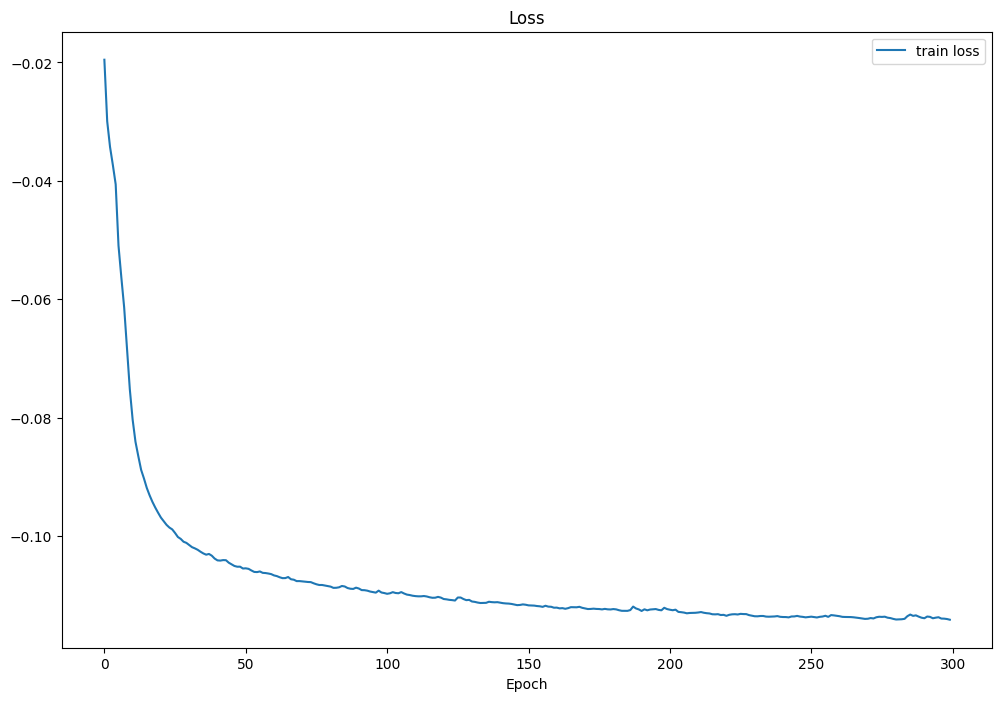

Epoch:  75%|███████▌  | 300/400 [1:01:24<20:28, 12.28s/it] 


KeyboardInterrupt: 

In [223]:
model = train(image_features_dataloader, model, optimizer, modularity_loss, model_name = model_name)

In [354]:
torch.save(model.state_dict(), '{}.pth'.format(model_name))

In [18]:
def model_load(model, model_name):
    model.load_state_dict(torch.load('{}.pth'.format(model_name)))
    model.to(device)
    model.eval()
    return model

In [19]:
model = ACGTransformer(n_prototypes = NUM_PROTOTYPES,
                       depth = NUM_BLOCKS,
                       embedding_dim = EMB_DIM,
                       num_heads = NUM_HEADS,
                       mlp_dim = MLP_DIM,
                       use_self_attn = USE_SELF_ATTN)

model = model_load(model, model_name) 

In [20]:
model_name

'ACG_3e4_400_6_6_6'

In [22]:
def extract_multi_region_segmentations(model, 
                                       upsample_befor_hard_assig = False, 
                                       features_dir = 'data/VOC2012/features/dino_vits16/all_features.pth', 
                                       output_dir='./data/VOC2012/multi_region_segmentation/ACSeg', 
                                       infer_bg_index=True):
    model.eval()
    
    extract_utils.make_output_dir(output_dir)
    all_features = torch.load(features_dir)
    all_features['prototypes'] = torch.tensor([])
    image_features = torch.stack(all_features['k']).squeeze()[:, 1:, :]
    batch_size = 1024
    for i in tqdm(range(0, len(image_features), batch_size)):
        batch = image_features[i:i+batch_size].to(device)
        adjusted_prototypes = model(batch)
        batch_norm = F.normalize(batch, dim=2) # BxN_pixelsxC
        prototypes_norm = F.normalize(adjusted_prototypes, dim=2) # BxKxC
        soft_assig = (batch_norm@prototypes_norm.permute(0, 2, 1)).reshape(len(batch), NUM_PATCHES, NUM_PATCHES, -1) # BxN_PxN_PxK
        # TODO: Improve this step in the pipeline.
        # Background detection: we assume that the segment with the most border pixels is the 
        # background region. We will always make this region equal 0. 
        for j, idx in enumerate(all_features['id'][i:i+batch_size]):
            cur_soft_assig = soft_assig[j].detach().cpu().numpy()
            H_org, W_org = all_features['old_shape'][i+j]
            if upsample_befor_hard_assig:
                cur_soft_assig = cv2.resize(cur_soft_assig, dsize=(W_org, H_org), interpolation=cv2.INTER_NEAREST)
            cur_segmap = np.argmax(cur_soft_assig, axis=-1)
            output_file = str(Path(output_dir) / f'{idx}.png')
            if infer_bg_index:
                indices, normlized_counts = extract_utils.get_border_fraction(cur_segmap)
                bg_index = indices[np.argmax(normlized_counts)].item()
                bg_region = (cur_segmap == bg_index)
                zero_region = (cur_segmap == 0)
                cur_segmap[bg_region] = 0
                cur_segmap[zero_region] = bg_index   
                # permute prototypes also 
                adjusted_prototypes[j, [bg_index, 0]] = adjusted_prototypes[j, [0, bg_index]]            
            
            Image.fromarray(cur_segmap.astype(np.uint8)).convert('L').save(output_file)
        
        all_features['prototypes'] = torch.cat((all_features['prototypes'], adjusted_prototypes.detach().cpu()))
            
    torch.save(all_features, features_dir)

In [44]:
extract_multi_region_segmentations(model, upsample_befor_hard_assig=False, output_dir='./data/VOC2012/multi_region_segmentation/ACSegPatched')

100%|██████████| 17/17 [00:47<00:00,  2.82s/it]


In [13]:
def plot_segmentation(image_id):
    img = np.array(Image.open(str(Path(f'./data/VOC2012/images/{image_id}.jpg'))))
    dsm_segmap = np.array(Image.open(str(Path(f'./data/VOC2012/multi_region_segmentation/laplacian/{image_id}.png'))))
    acs_segmap = np.array(Image.open(str(Path(f'./data/VOC2012/multi_region_segmentation/ACSeg/{image_id}.png')))) 
    acs_segmap_patched = np.array(Image.open(str(Path(f'./data/VOC2012/multi_region_segmentation/ACSegPatched/{image_id}.png')))) 
    
    f, ax = plt.subplots(2,2, figsize=(12, 12))
    ax[0, 0].imshow(img)
    ax[0, 0].set(title='Original Image')
    ax[0, 1].imshow(dsm_segmap)
    ax[0, 1].set(title='DSM Segmentation')
    ax[1, 0].imshow(acs_segmap)
    ax[1, 0].set(title='ACSeg Segmentation')
    ax[1, 1].imshow(acs_segmap_patched)
    ax[1, 1].set(title='ACSeg Segmentation patched')
    plt.show()
    
    return img, acs_segmap

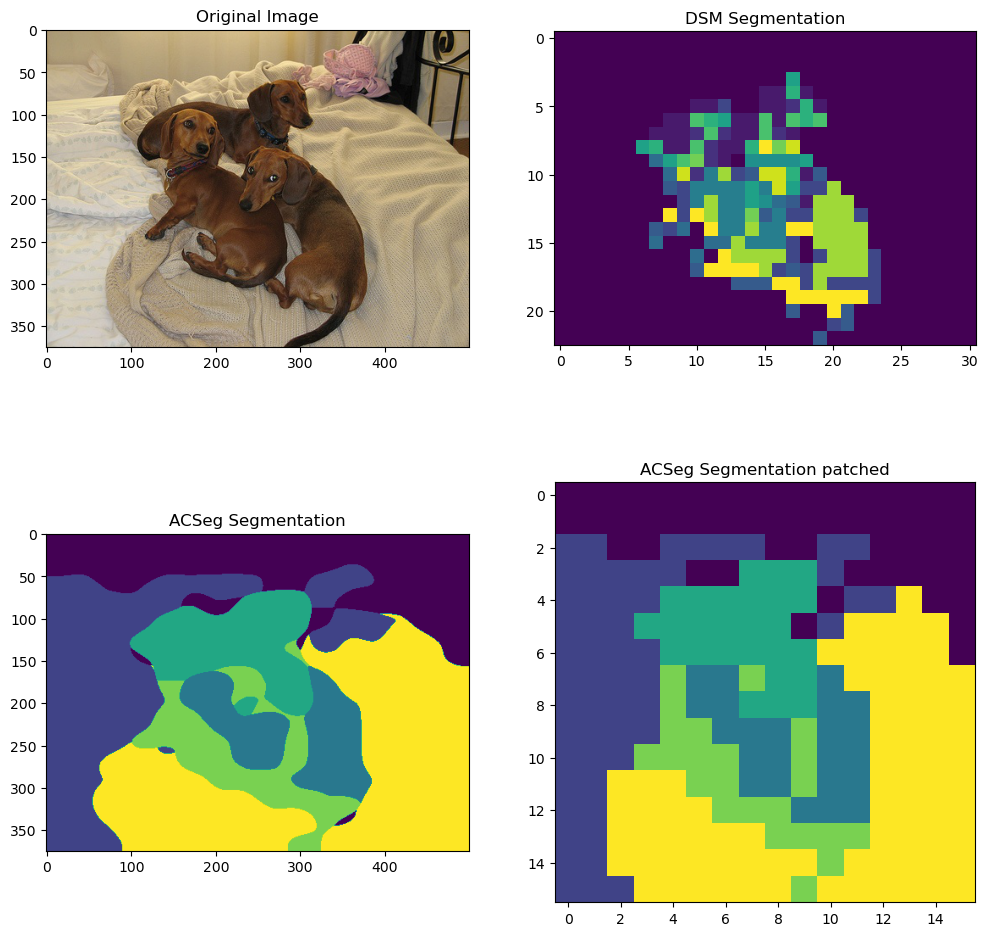

In [14]:
plot_segmentation('2007_001239');

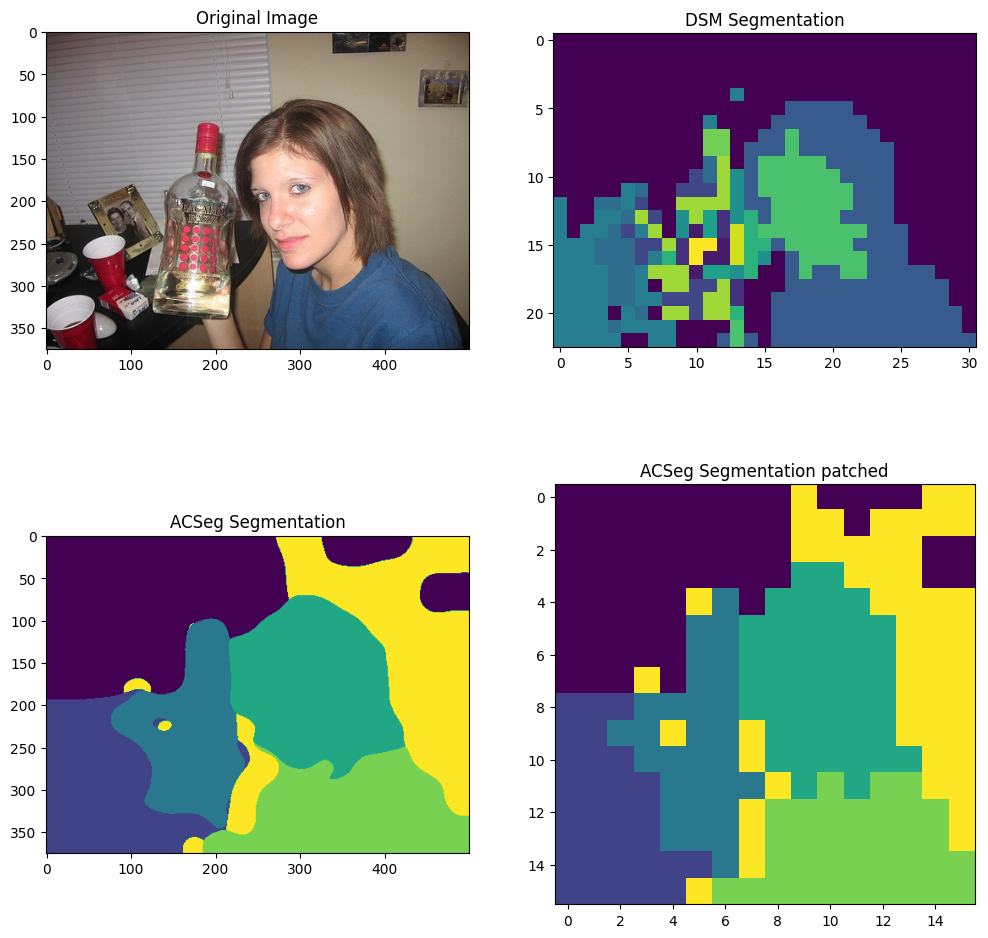

In [79]:
plot_segmentation('2007_000346');

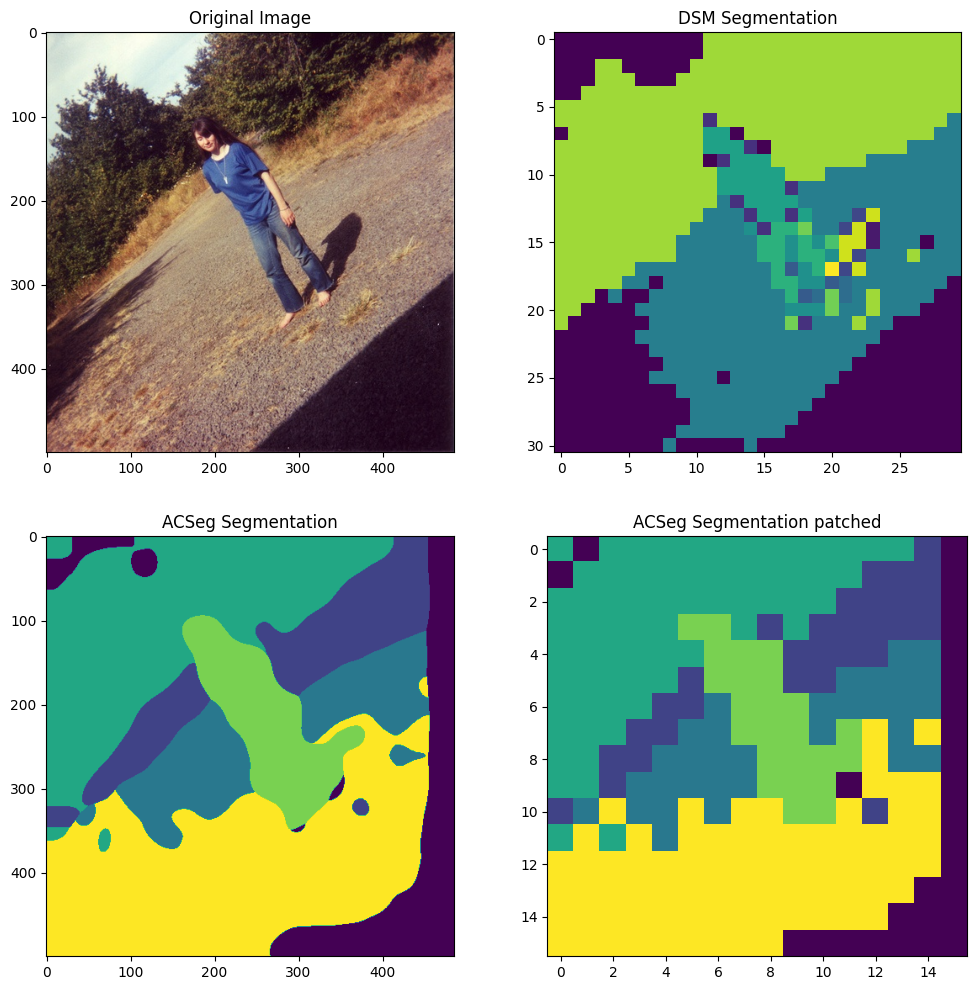

In [80]:
plot_segmentation('2007_000027');

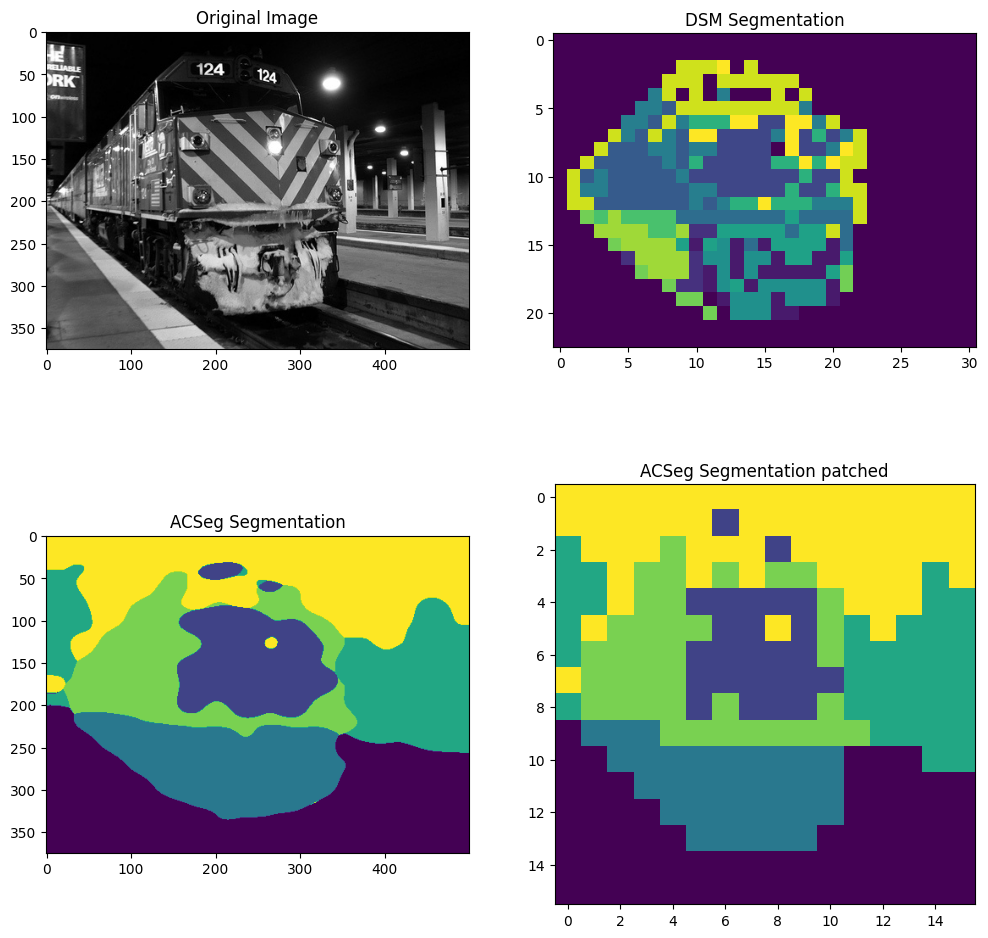

In [81]:
plot_segmentation('2007_000123');

In [59]:
from PIL import Image
import torchvision.transforms as T

def extract_bbox(
    features_dir = 'data/VOC2012/features/dino_vits16/all_features.pth',
    segmentations_dir='./data/VOC2012/multi_region_segmentation/ACSeg',
    output_file='./data/VOC2012/multi_region_bboxes/ACSeg/bboxes_e2_d5.pth',
    images_root="./data/VOC2012/images",
    image_segments_dir = './data/VOC2012/multi_region_segmentation/ACSegImageSegments',
    num_erode: int = 2,
    num_dilate: int = 5,
    skip_bg_index: bool = True,
    downsample_factor: Optional[int] = None,
):
    extract_utils.make_output_dir(image_segments_dir)
    extract_utils.make_output_dir(str(Path(output_file).parent), check_if_empty=False)
    dino_norm = extract_utils.get_transform('dino')
    
    all_features = torch.load(features_dir)
    all_bboxes = []
    for i in tqdm(range(len(all_features['id']))):
        image_id = all_features['id'][i]
        prototypes_feature = all_features['prototypes'][i]
        # Load the image
        image = np.array(Image.open(str(Path(images_root) / f'{image_id}.jpg'))) # H, W, 3
        # Load segmap of the image
        segmap = np.array(Image.open(str(Path(segmentations_dir) / f'{image_id}.png')))
        # Sizes
        H_org, W_org = all_features['old_shape'][i]
        H_new, W_new, Patch_size = all_features['new_shape_and_path_size'][i]
        
        # Mask Attention
        q_cls = all_features['q'][i].squeeze()[0] # 1 x D
        k = all_features['k'][i].squeeze() # 1+N_patches x D
        v = all_features['v'][i].squeeze() # 1+N_patches x D

        attn = q_cls @ k.permute(1, 0) # 1 x 1+N_patches
        attn = attn / math.sqrt(q_cls.shape[0])       
    
        # Get bounding boxes
        outputs = {'bboxes': [], 'bboxes_original_resolution': [], 'segment_indices': [], 'id': image_id, 
                   'format': "(xmin, ymin, xmax, ymax)", 'features': [], 'image_segment_id':[], 'features_without_cls': [], 
                  'features_with_cls': [], 'features_avg': [], 'features_avg_with_cls': []}
        for segment_index in sorted(np.unique(segmap).tolist()):
            if (not skip_bg_index) or (segment_index > 0):  # skip 0, because 0 is the background
                segment_id = f'{image_id}_{segment_index}'
                segment_file = str(Path(image_segments_dir) / f'{segment_id}.jpg')
                # if Path(segment_file).is_file():
                #     continue  # skip because already generated
    
                # Erode and dilate mask
                binary_mask = (segmap == segment_index)
                binary_mask = extract_utils.erode_or_dilate_mask(binary_mask, r=num_erode, erode=True)
                binary_mask = extract_utils.erode_or_dilate_mask(binary_mask, r=num_dilate, erode=False)

                # Find box
                mask = np.where(binary_mask == 1)
                ymin, ymax = min(mask[0]), max(mask[0]) + 1  # add +1 because excluded max
                xmin, xmax = min(mask[1]), max(mask[1]) + 1  # add +1 because excluded max
                bbox = [xmin, ymin, xmax, ymax]
                bbox_resized = bbox[:]
                # bbox_resized = np.array([x * Patch_size for x in bbox])  # rescale to image size
                # bbox_resized[0::2] = W_org * bbox_resized[0::2] / W_new
                # bbox_resized[1::2] = H_org * bbox_resized[1::2] / H_new
                bbox_features = [ymin, xmin, ymax, xmax]  # feature space coordinates are different
                #extract image segment
                # image_crop = image[ymin:ymax, xmin:xmax, :]
                # image_crop = cv2.normalize(image_crop, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                # image_crop[~binary_mask[ymin:ymax, xmin:xmax], :] = 0
                # image_crop = cv2.resize(image_crop, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
                # Image.fromarray((image_crop * 255).astype(np.uint8)).save(segment_file)

                # Append
                outputs['segment_indices'].append(segment_index)
                outputs['bboxes'].append(bbox)
                outputs['bboxes_original_resolution'].append(list(bbox_resized))
                outputs['image_segment_id'].append(segment_id)
                #outputs['features'].append(prototypes_feature[segment_index])
                # attn features
                flatten_mask = binary_mask.reshape(-1)
                masked_attn = torch.cat((attn[:1], attn[1:][flatten_mask]), dim=0)
                masked_attn = torch.softmax(masked_attn, dim=-1) 
                segment_feature_without_cls = masked_attn[1:] @ v[1:][flatten_mask]
                sum_of_features = v[1:][flatten_mask].sum(dim=0)
                cnt = sum(flatten_mask)
                outputs['features_without_cls'].append(segment_feature_without_cls)
                outputs['features_with_cls'].append(segment_feature_without_cls + masked_attn[0]*v[0])
                outputs['features_avg'].append(sum_of_features / cnt)
                outputs['features_avg_with_cls'].append((sum_of_features + v[0]) / (cnt+1))
                
        #outputs['features'] = torch.stack(outputs['features'])
        all_bboxes.append(outputs)
    torch.save(all_bboxes, output_file)
    print(f'All bboxes saved in {output_file}')

In [60]:
extract_bbox(
            features_dir = 'data/VOC2012/features/dino_vits16/all_features.pth',
            segmentations_dir='./data/VOC2012/multi_region_segmentation/ACSegPatched',
            output_file='./data/VOC2012/multi_region_bboxes/ACSeg/bboxes_e2_d5_Attn.pth',
            num_erode = 2,
            num_dilate = 5)

Output dir: data/VOC2012/multi_region_segmentation/ACSegImageSegments


Output dir already contains files. Continue? (y/n) >>  y


100%|██████████| 17125/17125 [06:07<00:00, 46.61it/s]


All bboxes saved in ./data/VOC2012/multi_region_bboxes/ACSeg/bboxes_e2_d5_Attn.pth


In [62]:
from io import BytesIO
    
def extract_bbox_features(
    images_root: str,
    bbox_file: str,
    model_name: str,
    output_file: str,
    image_segments_dir = './data/VOC2012/multi_region_segmentation/ACSegImageSegments',
):
    """
    Example:
        python extract.py extract_bbox_features \
            --model_name dino_vits16 \
            --images_root "./data/VOC2012/images" \
            --bbox_file "./data/VOC2012/multi_region_bboxes/fixed/bboxes_e2_d5.pth" \
            --output_file "./data/VOC2012/features/dino_vits16" \
            --output_file "./data/VOC2012/multi_region_bboxes/fixed/bbox_features_e2_d5.pth" \
    """

    # Load bounding boxes
    bbox_list = torch.load(bbox_file)
    total_num_boxes = sum(len(d['bboxes']) for d in bbox_list)
    print(f'Loaded bounding box list. There are {total_num_boxes} total bounding boxes.')

    # Models
    model_name_lower = model_name.lower()
    model, val_transform, patch_size, num_heads = extract_utils.get_model(model_name_lower)
    model.eval().to('cuda')

    # Loop over boxes
    for bbox_dict in tqdm(bbox_list):
        # features_crops = []
        # for segment_id in bbox_dict['image_segment_id']:
        # # Load segment as tensor
        #     image_filename = str(Path(image_segments_dir) / f'{segment_id}.jpg')
        #     image_crop = val_transform(Image.open(image_filename).convert('RGB'))  # (3, H, W)
        #     features_crop = model(image_crop.unsqueeze(0).to('cuda')).detach().cpu().squeeze()
        #     features_crops.append(features_crop)
        # bbox_dict['features'] = torch.stack(features_crops, dim=0)
        bbox_dict['features'] = torch.stack(bbox_dict['features_with_cls'], dim=0)
    
    # Save
    torch.save(bbox_list, output_file)
    print(f'Saved features to {output_file}')

In [63]:
extract_bbox_features(model_name = "dino_vits16",
    images_root = "./data/VOC2012/images",
    bbox_file = "./data/VOC2012/multi_region_bboxes/ACSeg/bboxes_e2_d5_Attn.pth",
    output_file = "./data/VOC2012/multi_region_bboxes/ACSeg/bbox_features.pth",
    image_segments_dir = './data/VOC2012/multi_region_segmentation/ACSegImageSegments')

Loaded bounding box list. There are 85598 total bounding boxes.


Downloading: "https://github.com/facebookresearch/dino/archive/main.zip" to /home/bobokhon/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /home/bobokhon/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

100%|██████████| 17125/17125 [00:00<00:00, 101707.20it/s]


Saved features to ./data/VOC2012/multi_region_bboxes/ACSeg/bbox_features.pth


# Steps that can be improved 

1. Instead of using patch representation, use a pixel-level representation.
2. Regarding the architecture of the ACG: Should we train initial prototypes? Generally, does the architecture make sense?
3. In the modularity loss, maybe we shouldn't delete diagonal elements.
4. Train for more epochs. Choose a better learning rate (lr) and weight decay (wd).
5. Maybe we can find a better way of determining bounding boxes? Also, consider a better method for resizing the segmentation map to the initial image size (currently, we use simple interpolation).

### Results

|Num Prototypes | Architecture| Mean IoU|
| --- | --- | --- |
| **5** | ACSeg + Crop + KMean | 21.7|
| **5** | ACSeg + Prototypes Feature + KMean | 9.07 |
| **5** | ACSeg + Crop + Matting + KMean | 9.01|